In [1]:
import addict
import copy
import gmsh
import matplotlib
import meshio
import pyproj
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from ismember import ismember


import celeri

%config InlineBackend.figure_format = "retina"

In [2]:
# Plot a single mesh; modified from celeri_vis.py
def plot_mesh(mesh, fill_value, ax):
    x_coords = mesh.coords[:, 0]
    y_coords = mesh.coords[:, 1]
    vertex_array = np.asarray(mesh.verts)

    if not ax:
        ax = plt.gca()

    xy = np.c_[x_coords, y_coords]
    verts = xy[vertex_array]
    pc = matplotlib.collections.PolyCollection(verts, edgecolor="none", cmap="rainbow")
    pc.set_array(fill_value)
    ax.add_collection(pc)
    ax.autoscale()
    plt.colorbar(pc, label=" ")

Info    : Meshing 1D...
Info    : Meshing curve 1 (Circle)
Info    : Done meshing 1D (Wall 6.2e-05s, CPU 8.7e-05s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00626563s, CPU 0.006402s)
Info    : 137 nodes 273 elements
Info    : Writing 'hector_mine_basal.msh'...
Info    : Done writing 'hector_mine_basal.msh'



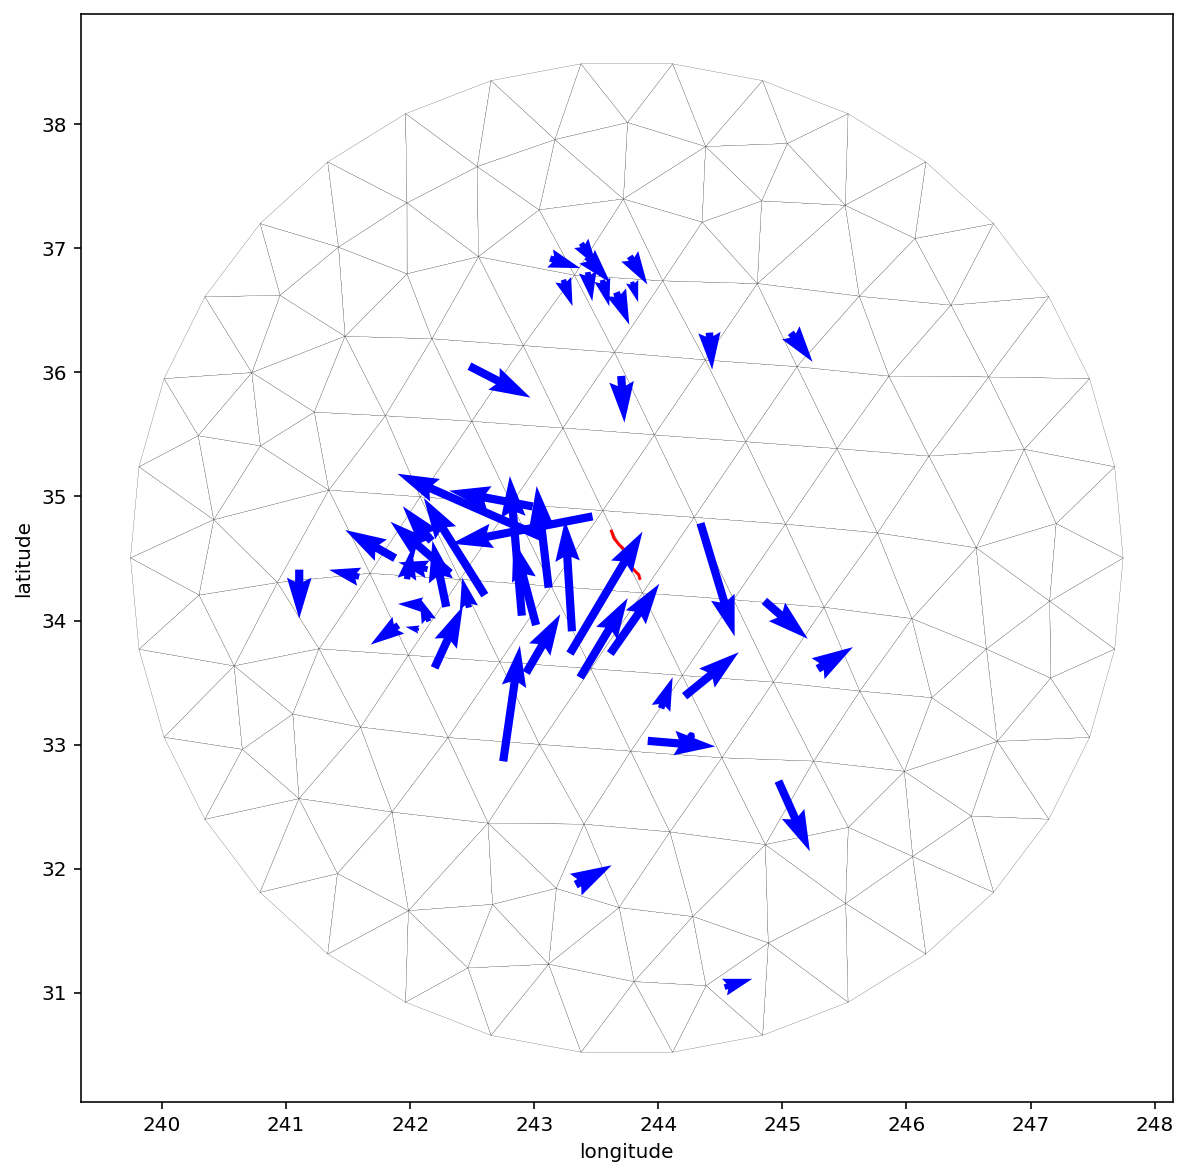

In [3]:
MESH_FILE_NAME = "hector_mine_basal.msh"
GPS_FILE_NAME = "hector_mine_postseismic_gps_freed_burgman_herring.csv"
FAULT_TRACE_FILE_NAME = "hector_mine_fault_trace_from_cfm.csv"
CMI_DEPTH = 20

# Read GPS
df_gps = pd.read_csv(GPS_FILE_NAME)

# Remove stations that clearly have longitude reported as northvelocity
df_gps = df_gps[df_gps.north > -100]

# Remove nearfield stations flagged with a trailing asterisk in the original paper
df_gps = df_gps[~df_gps.name.str.contains("\*")]
df_gps.lon = df_gps.lon + 360
df_gps = df_gps.reset_index(drop=True)

# Read fault trace
df_fault = pd.read_csv(FAULT_TRACE_FILE_NAME)
df_fault.lon = df_fault.lon + 360

# Create inital circular mesh
gmsh.initialize()
# Specify x, y, z, radius as first four arguments
gmsh.model.occ.addCircle(0.0, 0.0, 0.0, 4.0, 1, angle1=0.0, angle2=2 * np.pi)
gmsh.model.occ.addCurveLoop([1], 1)
gmsh.model.occ.addPlaneSurface([1], 1)
gmsh.model.occ.synchronize()
# Set the mesh size by changing the 10 (same units as the x, y, z, radius)
# gmsh.model.mesh.setSize([(0, 1)], 0.5)
gmsh.model.mesh.setSize([(0, 1)], 0.75)

# gmsh.model.mesh.setSize([(0, 1)], 2)

gmsh.model.mesh.generate(2)
gmsh.write(MESH_FILE_NAME)
gmsh.finalize()

# Read mesh
mesh = meshio.read(MESH_FILE_NAME)
n_tri = mesh.get_cells_type("triangle").shape[0]

# Move mesh to to be centered on the fault
mesh.points[mesh.get_cells_type("triangle")[:, :], 0] += df_fault.lon.mean()
mesh.points[mesh.get_cells_type("triangle")[:, :], 1] += df_fault.lat.mean()

# JPL style slight tilt of z-coordinates
base_depth = CMI_DEPTH
depth_gradient = 0.000001
mesh.points[mesh.get_cells_type("triangle")[:, :], 2] = base_depth + depth_gradient * (
    mesh.points[mesh.get_cells_type("triangle")[:, :], 1]
    - mesh.points[mesh.get_cells_type("triangle")[:, :], 1].min()
)

# Plot model geometry
plt.figure(figsize=(10, 10))
for i in range(0, n_tri):
    plt.fill(
        [
            mesh.points[mesh.get_cells_type("triangle")[:, 0], 0][i],
            mesh.points[mesh.get_cells_type("triangle")[:, 1], 0][i],
            mesh.points[mesh.get_cells_type("triangle")[:, 2], 0][i],
        ],
        [
            mesh.points[mesh.get_cells_type("triangle")[:, 0], 1][i],
            mesh.points[mesh.get_cells_type("triangle")[:, 1], 1][i],
            mesh.points[mesh.get_cells_type("triangle")[:, 2], 1][i],
        ],
        "-k",
        facecolor="w",
        edgecolor="k",
        linewidth=0.1,
    )

plt.plot(df_fault.lon, df_fault.lat, "-r")
plt.quiver(df_gps.lon, df_gps.lat, df_gps.east, df_gps.north, color="blue", zorder=10)
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.gca().set_aspect("equal")
plt.show()

In [4]:
a = base_depth + depth_gradient * (
    mesh.points[mesh.get_cells_type("triangle")[:, :], 1]
    - mesh.points[mesh.get_cells_type("triangle")[:, :], 1].min()
)
print(a.shape)

(238, 3)


# Read mesh as a celeri style mesh

In [5]:
GEOID = pyproj.Geod(ellps="WGS84")
KM2M = 1.0e3
M2MM = 1.0e3
RADIUS_EARTH = np.float64((GEOID.a + GEOID.b) / 2)


def triangle_normal(triangles):
    # The cross product of two sides is a normal vector
    # https://stackoverflow.com/questions/71346322/numpy-area-of-triangle-and-equation-of-a-plane-on-which-triangle-lies-on
    return np.cross(
        triangles[:, 1] - triangles[:, 0], triangles[:, 2] - triangles[:, 0], axis=1
    )


def triangle_area(triangles):
    # The norm of the cross product of two sides is twice the area
    # https://stackoverflow.com/questions/71346322/numpy-area-of-triangle-and-equation-of-a-plane-on-which-triangle-lies-on
    return np.linalg.norm(triangle_normal(triangles), axis=1) / 2.0


def sph2cart(lon, lat, radius):
    lon_rad = np.deg2rad(lon)
    lat_rad = np.deg2rad(lat)
    x = radius * np.cos(lat_rad) * np.cos(lon_rad)
    y = radius * np.cos(lat_rad) * np.sin(lon_rad)
    z = radius * np.sin(lat_rad)
    return x, y, z


def cart2sph(x, y, z):
    azimuth = np.arctan2(y, x)
    elevation = np.arctan2(z, np.sqrt(x**2 + y**2))
    r = np.sqrt(x**2 + y**2 + z**2)
    return azimuth, elevation, r


# Read mesh data - List of dictionary version
meshes = []
for i in range(1):
    meshes.append(addict.Dict())
    meshes[i].meshio_object = meshio.read(MESH_FILE_NAME)
    meshes[i].file_name = MESH_FILE_NAME
    meshes[i].verts = meshes[i].meshio_object.get_cells_type("triangle")

    # Expand mesh coordinates
    meshes[i].lon1 = meshes[i].meshio_object.points[meshes[i].verts[:, 0], 0]
    meshes[i].lon2 = meshes[i].meshio_object.points[meshes[i].verts[:, 1], 0]
    meshes[i].lon3 = meshes[i].meshio_object.points[meshes[i].verts[:, 2], 0]
    meshes[i].lat1 = meshes[i].meshio_object.points[meshes[i].verts[:, 0], 1]
    meshes[i].lat2 = meshes[i].meshio_object.points[meshes[i].verts[:, 1], 1]
    meshes[i].lat3 = meshes[i].meshio_object.points[meshes[i].verts[:, 2], 1]
    # meshes[i].dep1 = meshes[i].meshio_object.points[meshes[i].verts[:, 0], 2]
    # meshes[i].dep2 = meshes[i].meshio_object.points[meshes[i].verts[:, 1], 2]
    # meshes[i].dep3 = meshes[i].meshio_object.points[meshes[i].verts[:, 2], 2]

    # base_depth = CMI_DEPTH
    depth_gradient = 0.000001
    temp_depths = CMI_DEPTH + depth_gradient * (
        mesh.points[mesh.get_cells_type("triangle")[:, :], 1]
        - mesh.points[mesh.get_cells_type("triangle")[:, :], 1].min()
    )
    meshes[i].dep1 = temp_depths[:, 0]
    meshes[i].dep2 = temp_depths[:, 1]
    meshes[i].dep3 = temp_depths[:, 2]

    # meshes[i].dep1 = (
    #     CMI_DEPTH + 0 * meshes[i].meshio_object.points[meshes[i].verts[:, 0], 2]
    # )
    # meshes[i].dep2 = (
    #     CMI_DEPTH + 0 * meshes[i].meshio_object.points[meshes[i].verts[:, 1], 2]
    # )
    # meshes[i].dep3 = (
    #     CMI_DEPTH + 0 * meshes[i].meshio_object.points[meshes[i].verts[:, 2], 2]
    # )

    meshes[i].centroids = np.mean(
        meshes[i].meshio_object.points[meshes[i].verts, :], axis=1
    )
    # Cartesian coordinates in meters
    meshes[i].x1, meshes[i].y1, meshes[i].z1 = sph2cart(
        meshes[i].lon1,
        meshes[i].lat1,
        RADIUS_EARTH + KM2M * meshes[i].dep1,
    )
    meshes[i].x2, meshes[i].y2, meshes[i].z2 = sph2cart(
        meshes[i].lon2,
        meshes[i].lat2,
        RADIUS_EARTH + KM2M * meshes[i].dep2,
    )
    meshes[i].x3, meshes[i].y3, meshes[i].z3 = sph2cart(
        meshes[i].lon3,
        meshes[i].lat3,
        RADIUS_EARTH + KM2M * meshes[i].dep3,
    )

    # Cartesian triangle centroids
    meshes[i].x_centroid = (meshes[i].x1 + meshes[i].x2 + meshes[i].x3) / 3.0
    meshes[i].y_centroid = (meshes[i].y1 + meshes[i].y2 + meshes[i].y3) / 3.0
    meshes[i].z_centroid = (meshes[i].z1 + meshes[i].z2 + meshes[i].z3) / 3.0

    # Cross products for orientations
    tri_leg1 = np.transpose(
        [
            np.deg2rad(meshes[i].lon2 - meshes[i].lon1),
            np.deg2rad(meshes[i].lat2 - meshes[i].lat1),
            (1 + KM2M * meshes[i].dep2 / RADIUS_EARTH)
            - (1 + KM2M * meshes[i].dep1 / RADIUS_EARTH),
        ]
    )
    tri_leg2 = np.transpose(
        [
            np.deg2rad(meshes[i].lon3 - meshes[i].lon1),
            np.deg2rad(meshes[i].lat3 - meshes[i].lat1),
            (1 + KM2M * meshes[i].dep3 / RADIUS_EARTH)
            - (1 + KM2M * meshes[i].dep1 / RADIUS_EARTH),
        ]
    )
    meshes[i].nv = np.cross(tri_leg1, tri_leg2)
    azimuth, elevation, r = cart2sph(
        meshes[i].nv[:, 0],
        meshes[i].nv[:, 1],
        meshes[i].nv[:, 2],
    )
    meshes[i].strike = celeri.wrap2360(-np.rad2deg(azimuth))
    meshes[i].dip = 90 - np.rad2deg(elevation)
    meshes[i].dip_flag = meshes[i].dip != 90
    # meshes[i].smoothing_weight = mesh_param[i]["smoothing_weight"]
    # meshes[i].n_eigen = mesh_param[i]["n_eigen"]
    # meshes[i].top_slip_rate_constraint = mesh_param[i]["top_slip_rate_constraint"]
    # meshes[i].bot_slip_rate_constraint = mesh_param[i]["bot_slip_rate_constraint"]
    # meshes[i].side_slip_rate_constraint = mesh_param[i]["side_slip_rate_constraint"]
    meshes[i].n_tde = meshes[i].lon1.size

    # Calcuate areas of each triangle in mesh
    triangle_vertex_array = np.zeros((meshes[i].n_tde, 3, 3))
    triangle_vertex_array[:, 0, 0] = meshes[i].x1
    triangle_vertex_array[:, 1, 0] = meshes[i].x2
    triangle_vertex_array[:, 2, 0] = meshes[i].x3
    triangle_vertex_array[:, 0, 1] = meshes[i].y1
    triangle_vertex_array[:, 1, 1] = meshes[i].y2
    triangle_vertex_array[:, 2, 1] = meshes[i].y3
    triangle_vertex_array[:, 0, 2] = meshes[i].z1
    triangle_vertex_array[:, 1, 2] = meshes[i].z2
    triangle_vertex_array[:, 2, 2] = meshes[i].z3
    meshes[i].areas = triangle_area(triangle_vertex_array)
    celeri.get_mesh_edge_elements(meshes)

celeri.get_mesh_perimeter(meshes)
meshes[0].coords = meshes[0].meshio_object.points
meshes[0].coords[:, 0] += df_fault.lon.mean()
meshes[0].coords[:, 1] += df_fault.lat.mean()
meshes[0].coords[:, 2] = CMI_DEPTH
meshes[0].centroids[:, 0] += df_fault.lon.mean()
meshes[0].centroids[:, 1] += df_fault.lat.mean()
meshes[0].centroids[:, 2] = CMI_DEPTH
meshes[0].lon1[:] += df_fault.lon.mean()
meshes[0].lat1[:] += df_fault.lat.mean()
meshes[0].lon2[:] += df_fault.lon.mean()
meshes[0].lat2[:] += df_fault.lat.mean()
meshes[0].lon3[:] += df_fault.lon.mean()
meshes[0].lat3[:] += df_fault.lat.mean()

# Calculate partial derivatives

In [6]:
operators = addict.Dict()
material_lambda = 3e10
material_mu = 3e10
tri_operator = np.zeros((3 * len(df_gps), 3 * n_tri))

# Loop through each segment and calculate displacements for each slip component
for i in tqdm(
    range(n_tri),
    desc="Calculating cutde partials for triangles",
    colour="green",
):
    (
        vel_east_strike_slip,
        vel_north_strike_slip,
        vel_up_strike_slip,
    ) = celeri.get_tri_displacements(
        df_gps.lon.to_numpy(),
        df_gps.lat.to_numpy(),
        meshes,
        material_lambda,
        material_mu,
        tri_idx=i,
        strike_slip=1,
        dip_slip=0,
        tensile_slip=0,
    )
    (
        vel_east_dip_slip,
        vel_north_dip_slip,
        vel_up_dip_slip,
    ) = celeri.get_tri_displacements(
        df_gps.lon.to_numpy(),
        df_gps.lat.to_numpy(),
        meshes,
        material_lambda,
        material_mu,
        tri_idx=i,
        strike_slip=0,
        dip_slip=1,
        tensile_slip=0,
    )
    (
        vel_east_tensile_slip,
        vel_north_tensile_slip,
        vel_up_tensile_slip,
    ) = celeri.get_tri_displacements(
        df_gps.lon.to_numpy(),
        df_gps.lat.to_numpy(),
        meshes,
        material_lambda,
        material_mu,
        tri_idx=i,
        strike_slip=0,
        dip_slip=0,
        tensile_slip=1,
    )
    tri_operator[0::3, 3 * i] = np.squeeze(vel_east_strike_slip)
    tri_operator[1::3, 3 * i] = np.squeeze(vel_north_strike_slip)
    tri_operator[2::3, 3 * i] = np.squeeze(vel_up_strike_slip)
    tri_operator[0::3, 3 * i + 1] = np.squeeze(vel_east_dip_slip)
    tri_operator[1::3, 3 * i + 1] = np.squeeze(vel_north_dip_slip)
    tri_operator[2::3, 3 * i + 1] = np.squeeze(vel_up_dip_slip)
    tri_operator[0::3, 3 * i + 2] = np.squeeze(vel_east_tensile_slip)
    tri_operator[1::3, 3 * i + 2] = np.squeeze(vel_north_tensile_slip)
    tri_operator[2::3, 3 * i + 2] = np.squeeze(vel_up_tensile_slip)


# # operators.tri_station = celeri.get_tri_station_operator_okada(meshes, station, command)
# operators.tri_station = celeri.get_tde_to_velocities(meshes, station, command)
celeri.get_all_mesh_smoothing_matrices(meshes, operators)
smoothing_matrix = operators.smoothing_matrix[0].todense()
smoothing_matrix = np.delete(
    smoothing_matrix, np.arange(2, smoothing_matrix.shape[0], 3), axis=0
)
smoothing_matrix = np.delete(
    smoothing_matrix, np.arange(2, smoothing_matrix.shape[1], 3), axis=1
)

# Eliminate matrix entries for vertical displacments and tensile slip
tde_matrix = copy.deepcopy(tri_operator)
tde_matrix = np.delete(tde_matrix, np.arange(2, tde_matrix.shape[0], 3), axis=0)
tde_matrix = np.delete(tde_matrix, np.arange(2, tde_matrix.shape[1], 3), axis=1)

Calculating cutde partials for triangles: 100%|██████████| 238/238 [00:00<00:00, 842.91it/s]


# Solve with smoothing

constraint_matrix.shape=(68, 476)


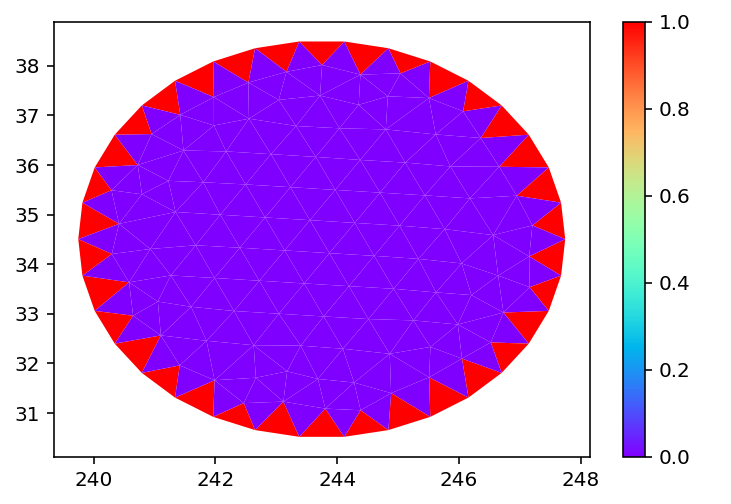

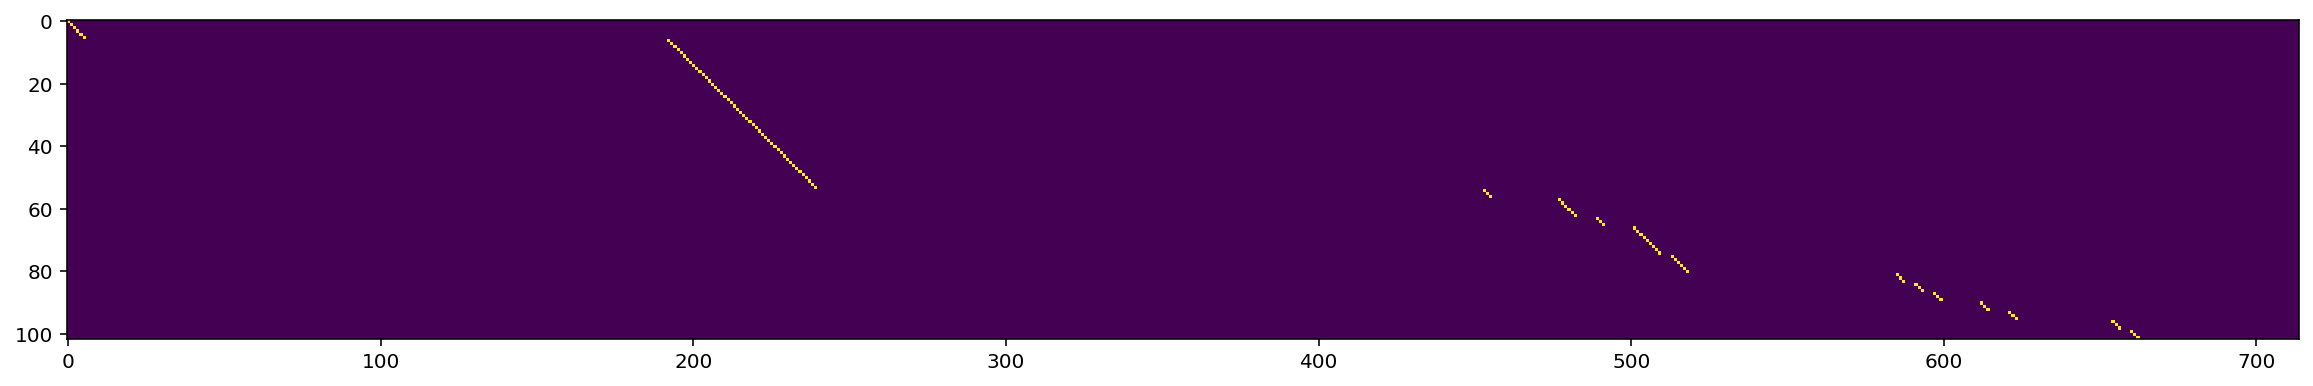

In [7]:
def get_mesh_edge_elements(meshes):
    # Find indices of elements lining top, bottom, and sides of each mesh

    celeri.get_ordered_edge_nodes(meshes)

    for i in range(len(meshes)):
        # for i in range(1, 2):

        # coords = meshes[i].meshio_object.points
        # coords = meshes[i].coords
        coords = meshes[0].meshio_object.points

        vertices = meshes[i].verts

        # Arrays of all element side node pairs
        side_1 = np.sort(np.vstack((vertices[:, 0], vertices[:, 1])).T, 1)
        side_2 = np.sort(np.vstack((vertices[:, 1], vertices[:, 2])).T, 1)
        side_3 = np.sort(np.vstack((vertices[:, 2], vertices[:, 0])).T, 1)

        # Sort edge node array
        sorted_edge_nodes = np.sort(meshes[i].ordered_edge_nodes, 1)

        # Indices of element sides that are in edge node array
        side_1_in_edge, side_1_in_edge_idx = ismember(sorted_edge_nodes, side_1, "rows")
        side_2_in_edge, side_2_in_edge_idx = ismember(sorted_edge_nodes, side_2, "rows")
        side_3_in_edge, side_3_in_edge_idx = ismember(sorted_edge_nodes, side_3, "rows")

        # Depths of nodes
        side_1_depths = np.abs(
            coords[
                np.column_stack(
                    (side_1[side_1_in_edge_idx, :], vertices[side_1_in_edge_idx, 2])
                ),
                2,
            ]
        )
        side_2_depths = np.abs(
            coords[
                np.column_stack(
                    (side_2[side_2_in_edge_idx, :], vertices[side_2_in_edge_idx, 0])
                ),
                2,
            ]
        )
        side_3_depths = np.abs(
            coords[
                np.column_stack(
                    (side_3[side_3_in_edge_idx, :], vertices[side_3_in_edge_idx, 1])
                ),
                2,
            ]
        )
        # Top elements are those where the depth difference between the non-edge node
        # and the mean of the edge nodes is greater than the depth difference between
        # the edge nodes themselves
        top1 = (side_1_depths[:, 2] - np.mean(side_1_depths[:, 0:2], 1)) > (
            np.abs(side_1_depths[:, 0] - side_1_depths[:, 1])
        )
        top2 = (side_2_depths[:, 2] - np.mean(side_2_depths[:, 0:2], 1)) > (
            np.abs(side_2_depths[:, 0] - side_2_depths[:, 1])
        )
        top3 = (side_3_depths[:, 2] - np.mean(side_3_depths[:, 0:2], 1)) > (
            np.abs(side_3_depths[:, 0] - side_3_depths[:, 1])
        )
        tops = np.full(len(vertices), False, dtype=bool)
        tops[side_1_in_edge_idx[top1]] = True
        tops[side_2_in_edge_idx[top2]] = True
        tops[side_3_in_edge_idx[top3]] = True
        meshes[i].top_elements = tops

        # Bottom elements are those where the depth difference between the non-edge node
        # and the mean of the edge nodes is more negative than the depth difference between
        # the edge nodes themselves
        bot1 = side_1_depths[:, 2] - np.mean(side_1_depths[:, 0:2], 1) < -np.abs(
            side_1_depths[:, 0] - side_1_depths[:, 1]
        )
        bot2 = side_2_depths[:, 2] - np.mean(side_2_depths[:, 0:2], 1) < -np.abs(
            side_2_depths[:, 0] - side_2_depths[:, 1]
        )
        bot3 = side_3_depths[:, 2] - np.mean(side_3_depths[:, 0:2], 1) < -np.abs(
            side_3_depths[:, 0] - side_3_depths[:, 1]
        )
        bots = np.full(len(vertices), False, dtype=bool)
        bots[side_1_in_edge_idx[bot1]] = True
        bots[side_2_in_edge_idx[bot2]] = True
        bots[side_3_in_edge_idx[bot3]] = True
        meshes[i].bot_elements = bots

        # Side elements are a set difference between all edges and tops, bottoms
        sides = np.full(len(vertices), False, dtype=bool)
        sides[side_1_in_edge_idx] = True
        sides[side_2_in_edge_idx] = True
        sides[side_3_in_edge_idx] = True
        sides[np.where(tops != 0)] = False
        sides[np.where(bots != 0)] = False
        meshes[i].side_elements = sides


def get_tde_slip_rate_constraints_3_component(meshes, operators):
    """Construct TDE slip rate constraint matrices for each mesh.
    These are essentially identity matrices, used to set TDE slip
    rates on elements lining the edges of the mesh, as controlled
    by input parameters
    top_slip_rate_constraint,
    bot_slip_rate_constraint,
    side_slip_rate_constraint

    Args:
        meshes (List): list of mesh dictionaries
        operators (Dict): dictionary of linear operators
    """
    for i in range(len(meshes)):
        # Empty constraint matrix
        tde_slip_rate_constraints = np.zeros((3 * meshes[i].n_tde, 3 * meshes[i].n_tde))
        # Top constraints
        if meshes[i].top_slip_rate_constraint > 0:
            # Indices of top elements
            top_indices = np.asarray(np.where(meshes[i].top_elements))
            # Indices of top elements' 3 slip components
            top_idx = celeri.get_3component_index(top_indices)
            tde_slip_rate_constraints[top_idx, top_idx] = 1
        # Bottom constraints
        if meshes[i].bot_slip_rate_constraint > 0:
            # Indices of bottom elements
            bot_indices = np.asarray(np.where(meshes[i].bot_elements))
            # Indices of bottom elements' 3 slip components
            bot_idx = celeri.get_3component_index(bot_indices)
            tde_slip_rate_constraints[bot_idx, bot_idx] = 1
        # Side constraints
        if meshes[i].side_slip_rate_constraint > 0:
            # Indices of side elements
            side_indices = np.asarray(np.where(meshes[i].side_elements))
            # Indices of side elements' 3 slip components
            side_idx = celeri.get_3component_index(side_indices)
            tde_slip_rate_constraints[side_idx, side_idx] = 1
        # Eliminate blank rows
        sum_constraint_columns = np.sum(tde_slip_rate_constraints, 1)
        tde_slip_rate_constraints = tde_slip_rate_constraints[
            sum_constraint_columns > 0, :
        ]
        operators.tde_slip_rate_constraints[i] = tde_slip_rate_constraints
        meshes[i].n_tde_constraints = np.sum(sum_constraint_columns > 0)


meshes[0].coords = meshes[0].meshio_object.points

get_mesh_edge_elements(meshes)
edge_elemnt_idx = np.concatenate(
    (
        np.where(meshes[0].top_elements == True)[0],
        np.where(meshes[0].bot_elements == True)[0],
        np.where(meshes[0].side_elements == True)[0],
    )
)
show_edge_mesh = np.zeros(meshes[0].verts.shape[0])
show_edge_mesh[edge_elemnt_idx] = 1
plot_mesh(meshes[0], show_edge_mesh, plt.gca())

for i in range(len(meshes)):
    meshes[i].n_tde = meshes[i].verts.shape[0]

# Set flag for boundary conditons applied to interestign mesh edges
meshes[0].top_slip_rate_constraint = 1
meshes[0].bot_slip_rate_constraint = 1
meshes[0].side_slip_rate_constraint = 1

get_tde_slip_rate_constraints_3_component(meshes, operators)
plt.figure(figsize=(20, 8))
plt.imshow(operators.tde_slip_rate_constraints[0])
constraint_matrix = np.copy(operators.tde_slip_rate_constraints[0])

constraint_matrix = np.delete(
    constraint_matrix, np.arange(2, constraint_matrix.shape[0], 3), axis=0
)
constraint_matrix = np.delete(
    constraint_matrix, np.arange(2, constraint_matrix.shape[1], 3), axis=1
)

print(f"{constraint_matrix.shape=}")

In [8]:
# Assemble matrices
n_constraints = constraint_matrix.shape[0]
assembled_mat = np.zeros((2 * len(df_gps) + 2 * n_tri + n_constraints, 2 * n_tri))

# Insert elastic partials
# assembled_mat[0 : 2 * len(df_gps), :] = disp_mat.reshape((-1, 3 * ntri))
assembled_mat[0 : 2 * len(df_gps), :] = tde_matrix

# Insert smoothing matrices
source_row_start = 2 * len(df_gps)
source_row_end = 2 * len(df_gps) + 2 * n_tri
assembled_mat[source_row_start:source_row_end, :] = 1e9 * smoothing_matrix

# Insert clip constraint matrix
assembled_mat[source_row_end::, :] = 1e0 * constraint_matrix

# Assemble weighting vector
smoothing_weight = 1e20
weights = np.ones((np.shape(assembled_mat)[0], 1))
weights[source_row_start:] = smoothing_weight

In [9]:
data_vector_smooth = np.zeros(2 * len(df_gps) + 2 * n_tri + n_constraints)
data_vector_smooth[np.arange(0, 100, 2)] = df_gps.east.values
data_vector_smooth[np.arange(1, 100, 2)] = df_gps.north.values

est_slip_smooth = (
    np.linalg.inv(assembled_mat.T @ assembled_mat)
    @ assembled_mat.T
    @ data_vector_smooth
)

est_slip_smooth = np.linalg.pinv(assembled_mat) @ data_vector_smooth

predictions_smooth = assembled_mat @ est_slip_smooth
predictions_east_smooth = predictions_smooth[np.arange(0, 100, 2)]
predictions_north_smooth = predictions_smooth[np.arange(1, 100, 2)]

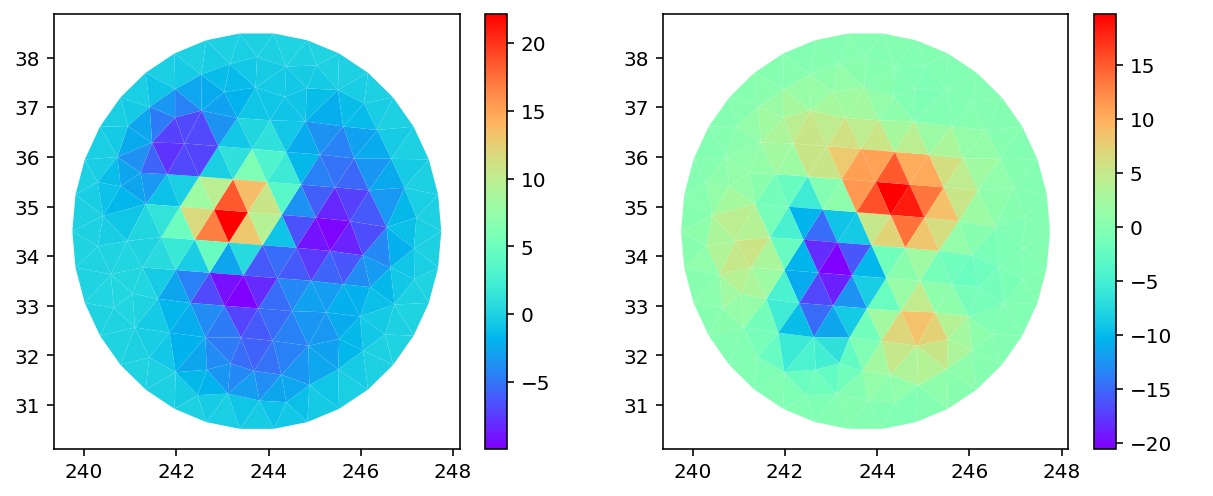

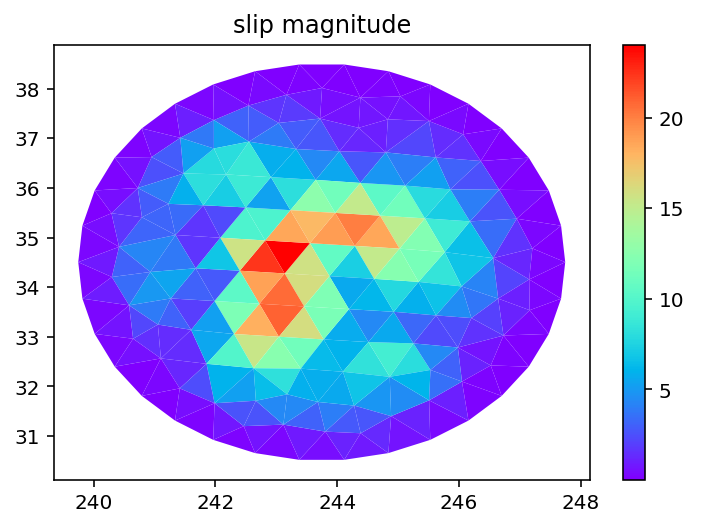

In [10]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plot_mesh(meshes[0], est_slip_smooth[0::2], plt.gca())
plt.subplot(1, 2, 2)
plot_mesh(meshes[0], est_slip_smooth[1::2], plt.gca())
plt.show()

plt.figure()
plt.title("slip magnitude")
plot_mesh(
    meshes[0],
    np.sqrt(est_slip_smooth[0::2] ** 2.0 + est_slip_smooth[1::2] ** 2.0),
    plt.gca(),
)
plt.show()

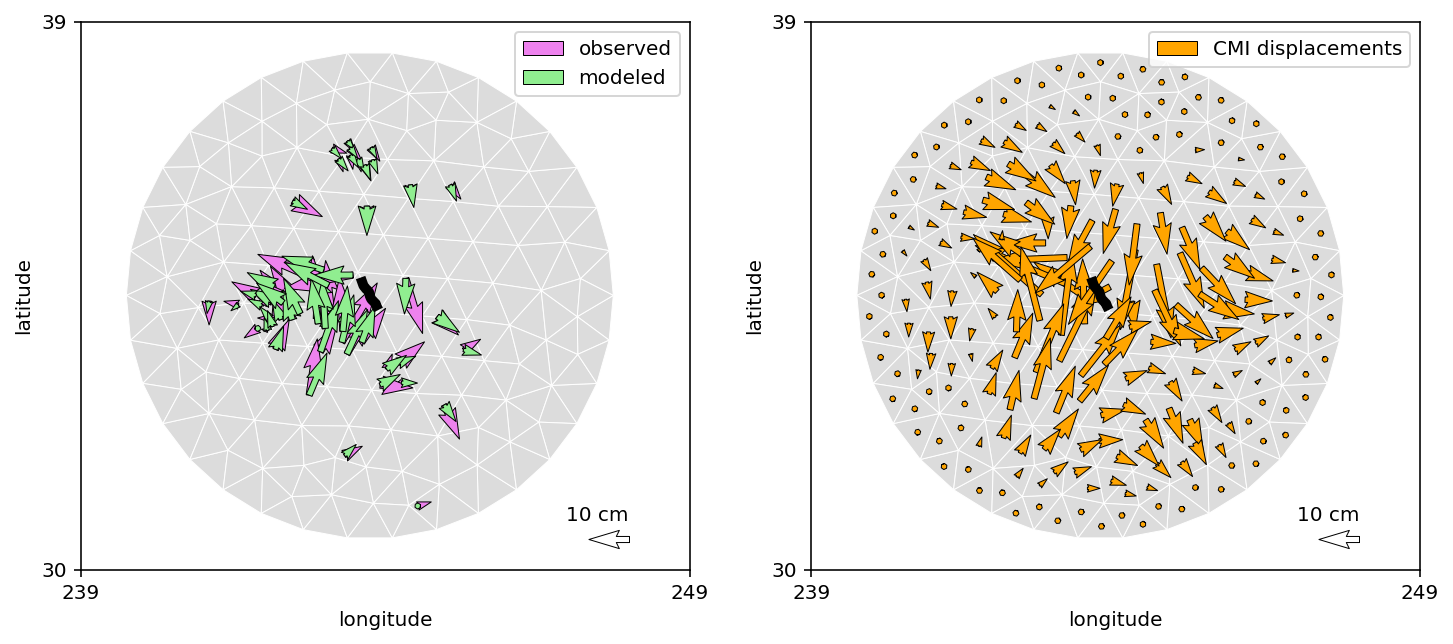

In [11]:
# Plot model geometry
QUIVER_SCALE = 1.5e2

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for i in range(0, n_tri):
    plt.fill(
        [
            mesh.points[mesh.get_cells_type("triangle")[:, 0], 0][i],
            mesh.points[mesh.get_cells_type("triangle")[:, 1], 0][i],
            mesh.points[mesh.get_cells_type("triangle")[:, 2], 0][i],
        ],
        [
            mesh.points[mesh.get_cells_type("triangle")[:, 0], 1][i],
            mesh.points[mesh.get_cells_type("triangle")[:, 1], 1][i],
            mesh.points[mesh.get_cells_type("triangle")[:, 2], 1][i],
        ],
        "-k",
        facecolor="gainsboro",
        edgecolor="white",
        linewidth=0.5,
    )


plt.plot(df_fault.lon, df_fault.lat, "-k", linewidth=5, zorder=20)
plt.quiver(
    df_gps.lon,
    df_gps.lat,
    df_gps.east,
    df_gps.north,
    color="blue",
    zorder=10,
    label="observed",
    scale=QUIVER_SCALE,
    facecolor="violet",
    edgecolor="k",
    linewidth=0.5,
    width=0.01,
)
plt.quiver(
    df_gps.lon,
    df_gps.lat,
    predictions_east_smooth,
    predictions_north_smooth,
    color="g",
    zorder=10,
    label="modeled",
    scale=QUIVER_SCALE,
    facecolor="lightgreen",
    edgecolor="k",
    linewidth=0.5,
    width=0.01,
)

plt.quiver(
    248,
    30.5,
    -10,
    0,
    color="r",
    zorder=25,
    scale=QUIVER_SCALE,
    facecolor="white",
    edgecolor="k",
    linewidth=0.5,
    width=0.01,
)
plt.text(248, 30.8, "10 cm", horizontalalignment="right")

plt.xlim([239, 249])
plt.ylim([30, 39])
plt.xticks([239, 249])
plt.yticks([30, 39])
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.gca().set_aspect("equal")
plt.legend()

plt.subplot(1, 2, 2)
for i in range(0, n_tri):
    plt.fill(
        [
            mesh.points[mesh.get_cells_type("triangle")[:, 0], 0][i],
            mesh.points[mesh.get_cells_type("triangle")[:, 1], 0][i],
            mesh.points[mesh.get_cells_type("triangle")[:, 2], 0][i],
        ],
        [
            mesh.points[mesh.get_cells_type("triangle")[:, 0], 1][i],
            mesh.points[mesh.get_cells_type("triangle")[:, 1], 1][i],
            mesh.points[mesh.get_cells_type("triangle")[:, 2], 1][i],
        ],
        "-k",
        facecolor="gainsboro",
        edgecolor="white",
        linewidth=0.5,
    )
plt.plot(df_fault.lon, df_fault.lat, "-k", linewidth=5, zorder=25)

plt.quiver(
    meshes[0].centroids[:, 0],
    meshes[0].centroids[:, 1],
    -est_slip_smooth[0::2],
    -est_slip_smooth[1::2],
    color="r",
    zorder=20,
    label="CMI displacements",
    scale=QUIVER_SCALE,
    facecolor="orange",
    edgecolor="k",
    linewidth=0.5,
    width=0.01,
)

plt.quiver(
    248,
    30.5,
    -10,
    0,
    color="r",
    zorder=25,
    scale=QUIVER_SCALE,
    facecolor="white",
    edgecolor="k",
    linewidth=0.5,
    width=0.01,
)
plt.text(248, 30.8, "10 cm", horizontalalignment="right")

plt.xlim([239, 249])
plt.ylim([30, 39])
plt.xticks([239, 249])
plt.yticks([30, 39])
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.gca().set_aspect("equal")
plt.legend()
plt.savefig("hector_mine_summary.pdf")
plt.savefig("hector_mine_summary.png", dpi=500)
plt.show()